## Simulation Question 1:

Loading MNIST train data set from $\texttt{keras}$ library

In [187]:
from keras.datasets import mnist

(train_X, _), (_, _) = mnist.load_data()

patching the training images

In [210]:
import numpy as np

m = 8  # patch size
image_size = train_X[0].shape[1]
num_images = 1000  # number of images to use
patches_per_image = ((image_size - m + 1) ** 2)  # number of patches per image
num_patches = num_images * patches_per_image  # total number of patches

patches = np.zeros((num_patches, m ** 2))  # initialize array to hold patches

patch_count = 0  # initialize patch counter

for i in range(num_images):
    image = train_X[i]
    patches_view = np.lib.stride_tricks.as_strided(
        image, shape=(image_size - m + 1, image_size - m + 1, m, m), strides=image.strides * 2)
    patches_reshaped = patches_view.reshape((-1, m ** 2))
    patches[patch_count:patch_count + patches_reshaped.shape[0]] = patches_reshaped
    patch_count += patches_reshaped.shape[0]

## Simulation Question 2:

In [211]:
from sklearn.mixture import GaussianMixture

# Fit GMM model
gmm = GaussianMixture(n_components=11, max_iter=100)
gmm.fit(patches)

GaussianMixture(n_components=11)

($\textbf{Don't run the cell always!}$)\
We use it when we want to save the needed parameters of our GMM model to use them later without waiting too much for the above cell to run.

In [81]:
from google.colab import files

path = '/content/cov_k11m8.npy'
np.save( path ,gmm.covariances_)
files.download(path)

path = '/content/mean_k11m8.npy'
np.save( path ,gmm.means_)
files.download(path)

path = '/content/wei_k11m8.npy'
np.save( path ,gmm.weights_)
files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

($\textbf{Don't run the cell always!}$)\
We use it when we want to load the GMM model we have been saved before

In [225]:
import numpy as np
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=11, max_iter=100)
gmm.covariances_ = np.load('cov_11.npy')
gmm.means_ = np.load('mean_11.npy')
gmm.weights_ = np.load('wei_11.npy')
gmm.n_components = 11

## Simulation Question 3 & 4:

Extracting original and corrupted images(from the train set)

In [226]:
from scipy.stats import multivariate_normal
import zipfile
import numpy as np
from PIL import Image

# Define image size
image_size = (28, 28)

# Define paths to zip file and folders
zip_path = 'MNIST-m=8.zip'
original_folder = '/original/'
corrupted_folder = '/corrupted/'
indexes = range(1, 218) , range(222, 301)

# Open zip file and extract images
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    # Extract original images
    original_images = []
    for i in range(1, 301):
        if i in [218, 219, 220, 221]:
            continue
        filename = f'MNIST{original_folder}{i}.png'
        with zip_file.open(filename) as image_file:
            image = Image.open(image_file).convert('L')
            image = np.array(image.resize(image_size))
            original_images.append(image)
    original_images = np.array(original_images)

    # Extract corrupted images
    corrupted_images = []
    for i in range(1, 301):
        if i in [218, 219, 220, 221]:
            continue
        filename = f'MNIST{corrupted_folder}{i}.png'
        with zip_file.open(filename) as image_file:
            image = Image.open(image_file).convert('L')
            image = np.array(image.resize(image_size))
            corrupted_images.append(image)
    corrupted_images = np.array(corrupted_images)

($\textbf{Don't run the cell when you want to use original images!}$)\
Extracting original and corrupted images(from the test set)

In [99]:
from scipy.stats import multivariate_normal
import zipfile
import numpy as np
from PIL import Image

# Define image size
image_size = (28, 28)

# Define paths to zip file and folders
zip_path = 'MNIST-m=8.zip'
corrupted_folder = '/corrupted/'
indexes = range(1, 218) , range(222, 301)

# Open zip file and extract images
with zipfile.ZipFile(zip_path, 'r') as zip_file:

    # Extract corrupted images
    corrupted_images = []
    for i in range(1, 301):
        if i in [218, 219, 220, 221]:
            continue
        filename = f'MNIST{corrupted_folder}{i}.png'
        with zip_file.open(filename) as image_file:
            image = Image.open(image_file).convert('L')
            image = np.array(image.resize(image_size))
            corrupted_images.append(image)
    corrupted_images = np.array(corrupted_images)

Extracting patches from the images

In [227]:
def patchExtractor(x, m):
  image_size = x[0].shape[1]
  num_images = x.shape[0]  # number of images to use
  patches_per_image = ((image_size - m + 1) ** 2)  # number of patches per image
  num_patches = num_images * patches_per_image  # total number of patches

  patches = np.zeros((num_patches, m ** 2))  # initialize array to hold patches

  patch_count = 0  # initialize patch counter

  for i in range(num_images):
      image = x[i]
      patches_view = np.lib.stride_tricks.as_strided(image, shape=(image_size - m + 1, image_size - m + 1, m, m), strides=image.strides * 2)
      patches_reshaped = patches_view.reshape((-1, m ** 2))
      patches[patch_count:patch_count + patches_reshaped.shape[0]] = patches_reshaped
      patch_count += patches_reshaped.shape[0]
  return patches

corrupted_patches = patchExtractor(corrupted_images, m)
original_patches = patchExtractor(original_images, m)

Determinig $\sigma^2$ from the Dataset using Cross-Validation method; In such a way that we splitt the train set(for a specific m value we are training the model with), into test and train $X$ and $Y$ arrays. Then using cross-validation determine the best value of $\sigma^2$ from them because the noise variance can be easily detected from them.




In [215]:
import numpy as np
from sklearn.model_selection import KFold
from scipy.stats import norm

# Define the possible values of sigma^2
sigmas = [5**2, 10**2, 20**2, 30**2, 50**2]

# Define the number of folds for cross-validation
k = 5

# Load the matrix W from the .npy file
W = np.load("W.npy")

# Create a cross-validation object
kf = KFold(n_splits=k)

# Initialize an array to store the mean squared errors for each value of sigma^2
mse = np.zeros(len(sigmas))

# Loop over the possible values of sigma^2
for i, sigma in enumerate(sigmas):
    # Initialize an array to store the squared errors for each fold
    se = np.zeros(k)

    # Loop over the folds
    for j, (train_idx, test_idx) in enumerate(kf.split(original_patches)):
        # Split the data into training and testing sets
        Z_train, Z_test = original_patches[train_idx], original_patches[test_idx]
        Y_train, Y_test = corrupted_patches[train_idx], corrupted_patches[test_idx]

        # Compute the predicted values of Y for the testing data
        Y_pred = np.dot(Z_test, W.T)

        # Compute the probability density function of the normal distribution
        # for each element of Y_pred and Y_test
        p = norm.pdf(Y_pred - Y_test, loc=0, scale=sigma)

        # Compute the negative log likelihood
        se[j] = -np.mean(np.log(p))

    # Compute the mean squared error over the folds
    mse[i] = np.mean(se)

# Find the index of the minimum mean squared error
idx = np.argmin(mse)

# Compute the best value of sigma^2
sigma_best = sigmas[idx]

# Print the best value of sigma^2
print("Best value of sigma^2:", sigma_best)

Best value of sigma^2: 100


Calculating the posterior for each patch and determining the best denoised patch using the formulas derived in Theory part.

In [228]:
from scipy.stats import multivariate_normal
import sys

# Load the matrix W from the .npy file
W = np.load("W.npy")

k = 45 # starting sample images selected(index)
l = 28 - m + 1
cor2 = corrupted_patches[l**2 * k: l**2 * (k+8) + 1 ]

# Calculate constant values
eye_matrix = np.eye(m ** 2)
noise_covariance = eye_matrix * (sigma_best) # 'sigma' should be the selected noise variance
covariances_y = np.zeros_like(gmm.covariances_)
small_value = 1e-7 * eye_matrix  # the small value added to the covariance matrix to make that become far from being singular
covariances_z_y = np.zeros_like(gmm.covariances_)
# Denoise the patches
denoised_patches = np.zeros_like(cor2)
for k in range(gmm.n_components):
        covariance = gmm.covariances_[k]
        # Compute pseudoinverse if matrix is nearly singular
        if np.linalg.cond(covariance) < 1/sys.float_info.epsilon:
            inv_covariance = np.linalg.inv(covariance)
        else:
            inv_covariance = np.linalg.pinv(covariance)

        covariances_y[k] = noise_covariance
        covariance_z_y = np.linalg.inv(np.linalg.inv(covariance) + np.dot(np.dot(W.T, np.linalg.inv(covariances_y[k])), W))

        covariance_z_y += small_value * np.trace(covariance_z_y)/(m**2)
        covariance_z_y = (covariance_z_y + covariance_z_y.T)/2
        covariances_z_y[k] = covariance_z_y

covariances_z_y.astype('float64')
means_z_y = np.zeros_like(gmm.means_)
for i in range(len(cor2)):
    patch = cor2[i]
    posterior_probs = np.zeros(gmm.n_components)

    for k in range(gmm.n_components):
        prior_prob = gmm.weights_[k]
        mean = gmm.means_[k]
        covariance = gmm.covariances_[k]

        means_z_y[k] = np.dot(covariances_z_y[k], np.dot(W.T, np.linalg.inv(covariances_y[k]).dot(patch)) + np.dot(np.linalg.inv(covariance), mean))

        means_z_y.astype('float64')
        patch.astype('float64')

        posterior_probs[k] = prior_prob * multivariate_normal.pdf(patch, mean=means_z_y[k], cov=covariance_z_y)

    # Find the component with maximum probability
    max_component = np.argmax(posterior_probs)

    # Estimate the mean of the selected component
    denoised_patches[i] = means_z_y[max_component]


# Reshape denoised patches to m × m size
denoised_patches = denoised_patches.reshape((-1, m, m))

Depatching the denoised patches to result in the denoised images as desired in the Project descriptions.

In [229]:
l = 29 - m
denoised_images = np.zeros((9, 28, 28), dtype=np.float64)  # Specify dtype as float64
count = np.zeros((28, 28))
for i in range(28):
    for j in range(28):
        count[i, j] = 1 / (min(min(i + 1, 28 - i), m) * min(min(j + 1, 28 - j), m))

for n in range(len(cor2)):
    image_number = n // (l ** 2)
    col_number = n % l
    row_number = (n % (l ** 2)) // l
    denoised_images[image_number, row_number:row_number + m, col_number:col_number + m] += denoised_patches[n]
    #the next two line were mentioned in the project to be done but the result without them is much better
    #if(n + 1) % (l ** 2) == 0:
    #  denoised_images[image_number, :, :] /= max(max(denoised_images[image_number, :, :], key=max))/255


($\textbf{Don't run the cell always!}$)\
The next two cells are used when we want to save and download the denoised images.

In [153]:
from PIL import Image
import time

for i in range(31, 301):
        if i in [218, 219, 220, 221]:
            continue
        path = f'/content/{i}.png'
        if i in range (1, 218):
          image = denoised_images[i-1]
        else:
          image = denoised_images[i-5]

        image = Image.fromarray(np.uint8(image))
        # Convert the image to grayscale
        #image = image.convert('L')
        image.save(path)
        time.sleep(0.5)




In [181]:
for i in range(291, 301):
        if i in [218, 219, 220, 221]:
            continue
        path = f'/content/{i}.png'
        files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Calculating MSE between the original images and denoised ones.

In [77]:
def calculate_mse(x, y, num_images):

    image_size = original_images.shape[1]

    mse = 0.0

    for i in range(num_images):
        a = x[i].astype(np.int32)
        b = y[i].astype(np.int32)
        mse += np.mean((a - b) ** 2)

    mse /= num_images * image_size ** 2

    return mse

mse = calculate_mse(original_images[50:52], denoised_images[4:6], 1)
print(f'MSE for the two instance images with K = 11 and m = 20 is ', mse)

MSE for the two instance images with K = 11 and m = 20 is  8.52209528581841


Showing the result of denoising process for two instance images.\
The left one is denoise image, the middle one is the original one and the right is corrupted.

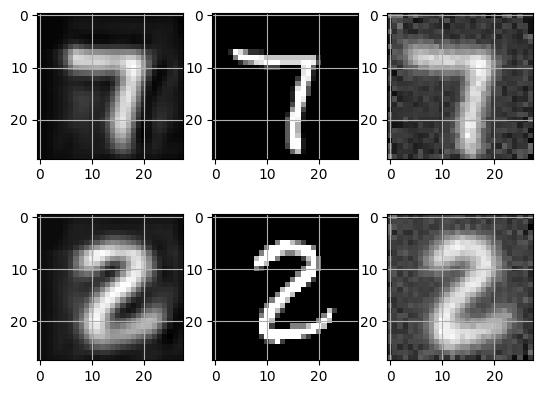

In [230]:
from pylab import *
from matplotlib import pyplot as plt
plt.subplot(2,3,1)
imshow(denoised_images[6],cmap='gray')
grid(True)
plt.subplot(2,3,2)
imshow(original_images[51],cmap='gray')
grid(True)
plt.subplot(2,3,3)
imshow(corrupted_images[51],cmap='gray')
grid(True)
plt.subplot(2,3,4)
imshow(denoised_images[5],cmap='gray')
grid(True)
plt.subplot(2,3,5)
imshow(original_images[50],cmap='gray')
grid(True)
plt.subplot(2,3,6)
imshow(corrupted_images[50],cmap='gray')
grid(True)

($\textbf{Don't run the cell always!}$)\
The result of comparing denoised images versus corrupted images(for test data with the best hyperparameters.)

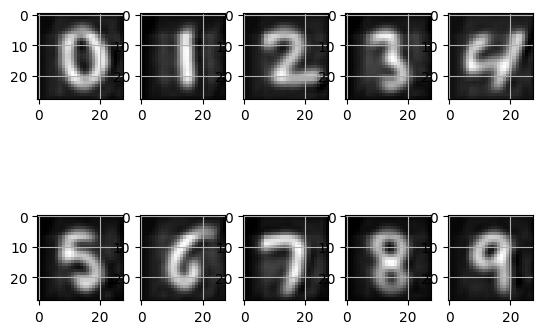

In [209]:
from pylab import *
from matplotlib import pyplot as plt
plt.subplot(2,5,1)
imshow(denoised_images[29],cmap='gray')
grid(True)
plt.subplot(2,5,2)
imshow(denoised_images[10],cmap='gray')
grid(True)
plt.subplot(2,5,3)
imshow(denoised_images[32],cmap='gray')
grid(True)
plt.subplot(2,5,4)
imshow(denoised_images[87],cmap='gray')
grid(True)
plt.subplot(2,5,5)
imshow(denoised_images[57],cmap='gray')
grid(True)
plt.subplot(2,5,6)
imshow(denoised_images[44],cmap='gray')
grid(True)
plt.subplot(2,5,7)
imshow(denoised_images[108],cmap='gray')
grid(True)
plt.subplot(2,5,8)
imshow(denoised_images[8],cmap='gray')
grid(True)
plt.subplot(2,5,9)
imshow(denoised_images[12],cmap='gray')
grid(True)
plt.subplot(2,5,10)
imshow(denoised_images[43],cmap='gray')
grid(True)